In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

In [2]:
import sys
sys.path.insert(0, '..')
import utils.dataloader as DL

data_train = DL.get_customer_data(DL.loadData('../../data/load1011.csv'), DL.loadPrice('../../data/price.csv'), customer=1)
data_eval = DL.get_customer_data(DL.loadData('../../data/load1112.csv'), DL.loadPrice('../../data/price.csv'), customer=1)

def reshape_data(df):
    # Reshape the DataFrame from a day-wise format to a continuous series format
    reshaped_data = df.values.flatten()  # Flatten the day-wise data into a single array
    return pd.DataFrame(reshaped_data)  # Convert back to DataFrame for consistency

# Assuming data_train[0], data_train[1], and data_train[2] are your load, PV, and price data respectively
load_data_reshaped = reshape_data(data_train[0])
pv_data_reshaped = reshape_data(data_train[1])
price_data_reshaped = pd.DataFrame(data_train[2].values)

print("Load data values {}, PV values {}, Price values {}".format(len(load_data_reshaped), len(pv_data_reshaped), len(price_data_reshaped)))

Load data values 17520, PV values 17520, Price values 17520


In [3]:
# Setup Environment

class BatteryEnvironment(gym.Env):
    def __init__(self, load_data, pv_data, price_data, max_battery=13.5, power_battery=4.6, eta=0.95):
        """
        Initialize the environment.

        :param load_data: Time series data for load (energy demand).
        :param pv_data: Time series data for photovoltaic (solar) energy production.
        :param price_data: Time series data for electricity prices.
        :param max_battery: The maximum capacity of the battery in kWh.
        :param power_battery: The power rating of the battery in kW (max power in or out).
        :param eta: The efficiency of the battery during charging/discharging.
        """
        self.load_data = load_data
        self.pv_data = pv_data
        self.price_data = price_data
        self.max_battery = max_battery
        self.power_battery = power_battery
        self.eta = eta

        self.current_step = 0
        self.current_battery = self.max_battery / 2 
        self.electricity_cost = 0.0
        
        # Define action space (1D continuous actions)
        self.action_space = gym.spaces.Box(low=np.array([-4.6]), high=np.array([4.6]), dtype=np.float32)

        # Define observation space (4D observations)
        self.observation_space = gym.spaces.Box(low=np.float32(np.zeros(4)), high=np.float32(np.ones(4)))
        
    def render(self, mode='human'):
        pass # Implement if environment visualization wanted

    def reset(self):
        """
        Reset the environment to the initial state for a new episode.

        :return: The initial observation of the environment.
        """
        self.current_step = 0
        self.current_battery = self.max_battery / 2  # Start with half charge
        self.electricity_cost = 0.0
        return self._next_observation()

    
    def _next_observation(self):
        """
        Generate the next observation based on the current state.

        :return: The current state represented as a normalized array including
                 the state of charge, load, electricity price, and PV production.
        """
        # Access the current state's load, PV, and price
        load = self.load_data[self.current_step][0]
        pv = self.pv_data[self.current_step][0]
        price = self.price_data[self.current_step][0]

        # Normalize the state
        state = np.array([
            self.current_battery / self.max_battery,
            load / np.max(self.load_data),
            price / np.max(self.price_data),
            pv / np.max(self.pv_data)
        ], dtype=np.float32)

        return state
    
    def step(self, action):
        """
        Take an action in the environment and proceed to the next state.

        :param action: The action to be taken, which affects the battery's state of charge.
        :return: A tuple containing the next state, reward from the action, 
                 a boolean indicating if the episode is done, and an empty dictionary.
        """
        # Implement the battery dynamics
        print("Action: ", action, " Power: ", self.power_battery)
        battery_action = action * self.power_battery
        battery_change = battery_action * self.eta

        # Load and PV data
        load = self.load_data[self.current_step][0]
        pv = self.pv_data[self.current_step][0]
        electricity_price = self.price_data[self.current_step][0]
        
        # Net load
        net_load = load - pv

        # Update SoE
        old_soe = self.current_battery
        new_soe = np.clip(old_soe + battery_change, 0, self.max_battery)
        self.current_battery = new_soe

        # Balance energy
        energy_from_grid = max(0, net_load + battery_change)
        energy_feed_in = max(0, -net_load - battery_change)

        # Calculate Costs and Profits
        cost = energy_from_grid * electricity_price
        profit = energy_feed_in * electricity_price * 0.7
        self.electricity_cost += profit - cost

        # Calculate reward
        reward = profit - cost

        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.load_data)-1
        #print("Done ", done, " , current_step ", self.current_step, " / ", len(self.load_data))

        return self._next_observation(), reward, done



env = BatteryEnvironment(load_data_reshaped.values, pv_data_reshaped.values, price_data_reshaped.values)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  4.599999904632568
Min Value of Action ->  -4.599999904632568


c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
# Setup Ornstein-Uhlenbeck process
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [5]:
#Setup Buffer
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [6]:
#Setup agents

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [7]:
# Hyperparameters
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Action:  -0.005313139711108008  Power:  4.6
Action:  0.051512197414668406  Power:  4.6
Action:  0.06597334408146979  Power:  4.6
Action:  0.07018864295597851  Power:  4.6
Action:  0.09708661567534449  Power:  4.6
Action:  0.18162986656879576  Power:  4.6
Action:  0.20446707119536264  Power:  4.6
Action:  0.2604420410209565  Power:  4.6
Action:  0.3081131820818287  Power:  4.6
Action:  0.4771907084513634  Power:  4.6
Action:  0.5325946006669127  Power:  4.6
Action:  0.5744477215519176  Power:  4.6
Action:  0.6251944831168804  Power:  4.6
Action:  0.6397055421092677  Power:  4.6
Action:  0.6658711219350484  Power:  4.6
Action:  0.6215032370400796  Power:  4.6
Action:  0.5237388320600124  Power:  4.6
Action:  0.41442789668534086  Power:  4.6
Action:  0.3311707127113791  Power:  4.6
Action:  0.260225317407245  Power:  4.6
Action:  0.23155058529646763  Power:  4.6
Action:  0.16448267557497473  Power:  4.6
Action:  0.16611271891514878  Power:  4.6
Action:  0.12007479266618978  Power:  4.6
Ac

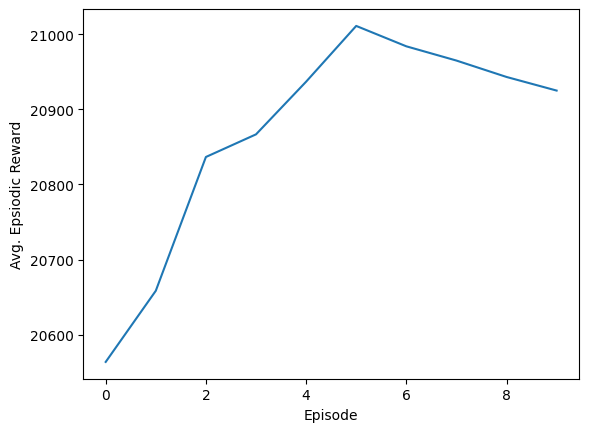

In [8]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()